<a href="https://colab.research.google.com/github/asegura4488/MetodosComputacionalesI/blob/main/ProyectoML/EvolutivoAnimGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy

In [365]:
# Configuracion de red neural
sigm1 = lambda x: np.tanh(x)
sigm2 = lambda x: np.maximum(0,x)
sigm3 = lambda x: 1/(1+np.exp(-x))
class Layer:


    def __init__(self,NC,NN,ActFun,rate=0.5):

        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate

        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )

    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]

    def SetMutate(self,rate):
        self.rate = rate

    def Mutate(self):

        self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))

        #self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        #self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [366]:
def GetBrain():
    l0 = Layer(2,8,sigm3)
    l1 = Layer(8,10,sigm3)
    l2 = Layer(10,1,sigm3)
    Brain = [l0,l1,l2]
    return Brain

In [367]:
Brain = GetBrain()

In [368]:
Brain[1].b

array([[ 5.45613215, -1.90934061, -1.46778912, -5.76852727, -2.75472053,
         3.41697547,  0.86715053,  1.58202737,  6.26981038,  6.31213794]])

In [369]:
class Robot:

    def __init__(self,dt,Brain,Id=0):

        self.Id = Id
        self.dt = dt
        self.Fitness = np.inf

        # Kinematics
        self.r = np.array([0.,0.])

        theta = np.random.uniform(0.,2*np.pi)
        #theta = 0. # Solo horizontal
        V = np.random.uniform(1.,1.2)
        self.v = np.array([V*np.cos(theta),V*np.sin(theta)])

        self.v0 = self.v # Guardar la velocidad inicial


        # Brain
        self.Brain = Brain
        self.Activation = 0.

    def GetR(self):
        return self.r

    def SetFitness(self):
        self.Fitness = (np.linalg.norm(self.r) - 1.)**2
        #self.Fitness = np.linalg.norm(self.v)
        #self.Fitness = np.abs(np.arctan2(self.r[1],self.r[0])) * 180  / np.pi
        #self.Fitness = np.arctan(self.r[1]/self.r[0])# * 180  / np.pi

    def GetFitness(self):
        return self.Fitness

    def Evolution(self):
        self.r += self.v*self.dt

    def Reset(self):

        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf

        # Coomo hay reemplazo, explorar con otro angulo
        theta = np.random.uniform(0.,2*np.pi)
        V = np.random.uniform(1.,1.2)
        self.v = np.array([V*np.cos(theta),V*np.sin(theta)])


    # Brain stuff
    def BrainActivation(self,x,threshold=0.8):

      for i in range(len(self.Brain)):
        if i == 0:
          output = self.Brain[i].Activation(x)
        else:
          output = self.Brain[i].Activation(output)

      self.Activation = np.round(output[0],4)

      if self.Activation >= threshold and np.linalg.norm(self.r) != 0.:
        self.v = np.array([0.,0.])

      return self.Activation

      # Qué hacer si se activa la red

    # Mutamos la configuracion de parametros en cada capa
    def Mutate(self):
      for i in range(len(self.Brain)):
        self.Brain[i].Mutate()

    def SetMutate(self,rate):
      for i in range(len(self.Brain)):
        self.Brain[i].SetMutate(rate)

    def GetBrain(self):
      return self.Brain

In [370]:
def GetRobots(N):

    Robots = []

    for i in range(N):
        # Creamos un red para cada bot
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)

    return Robots

In [372]:
dt = 0.05
t = np.arange(0.,5.,dt)
Robots = GetRobots(20)

In [373]:
def GetPlot():

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)

    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)

    return ax,ax1

In [374]:
def GetPlot1():

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2,projection='3d')

    return ax,ax1

In [375]:
def TimeEvolution(Robots,Plot=True):

    # Aca miramos las activaciones de cada robot
    Activation = np.zeros(len(Robots))

    for it in range(t.shape[0]):

        if Plot:
          clear_output(wait=True)
          ax,ax1 = GetPlot()
          ax.set_title('t = {:.3f}'.format(t[it]))

        for i,p in enumerate(Robots):
            # Aca movemos el robot por el plano
            p.Evolution()

            # Aqui va la activacion cerebral
            # La red debe interactuar con la posición del robot en el plano
            Activation[i] = p.BrainActivation(p.GetR())

            if Plot and i < 10:
              ax.scatter(p.r[0],p.r[1],label='Id: {}'.format(p.Id))
              ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
             # print(p.v)

        if Plot:
          ax1.plot(np.arange(0,len(Robots[:10]),1),Activation[:10],ls='--',marker='o',color='k')
          ax1.axhline(y=0.7,color='r',ls='--')
          ax1.set_ylim(0.,1.)
          ax.legend(loc=0)
          plt.show()
          time.sleep(0.01)

        #print(Activation)

In [376]:
#TimeEvolution(Robots,True)

In [382]:
def Genetic(Robots, epochs=200, Plot=True):

    N = int(0.6*len(Robots))

    Fitness = np.array([])

    for e in range(epochs):

        # Reiniciamos y mutamos pesos
        for p in Robots:
          p.Reset()
          p.Mutate()

        # Evolucionamos (episodios en aprendizaje por refuerzo)
        TimeEvolution(Robots,False)

        # Actualizamos fitness
        for p in Robots:
          p.SetFitness()


        # Elegimos los N más aptos
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False) # De menor a mayor


        Temp = [ r[1] for i,r in enumerate(scores) if i < N ]

        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])


        # Miramos fitness de cada robot
        Fitness_ = [ r.GetFitness() for i,r in enumerate(Robots) ]

        # Guardamos la aptitud promedio
        Fitness = np.append(Fitness, np.mean(Fitness_))
        #print(Fitness)

        # Ajustamos la mutacion
        if Fitness[-1] < 0.2:
          for p in Robots:
            p.SetMutate(0.2)
        elif Fitness[-1] < 0.1:
          for p in Robots:
            p.SetMutate(0.1)

        if e % 5 == 0 and Plot:

          clear_output(wait=True)


          Brain_ = Robots[0].GetBrain()
          # Creamos un robot de prueba con ese cerebro
          BestBot = Robot(dt,Brain_,Id=0)
          #for i in range(len(Brain)):
          #  print(Brain_[i].W,'\\')
          #  print(Brain_[i].b)


          ax,ax1 = GetPlot1()
          ax.set_title('epoch: {}'.format(e))
          ax.plot(Fitness,color='k',label='Fitness: {:.4f}'.format(Fitness[-1]))
          ax.legend(loc=0)

          # Pintar la respuesta
          x = np.linspace(-1.5,1.5,40)
          y = np.linspace(-1.5,1.5,40)
          X,Y = np.meshgrid(x,y)
          Respuesta = np.zeros_like(X)
          for i in range(40):
            for j in range(40):
               Respuesta[i,j]  = BestBot.BrainActivation(np.array([x[i],y[j]]))

          ax1.plot_surface(X,Y,Respuesta,cmap='viridis')

          plt.tight_layout()
          plt.show()
          time.sleep(0.001)

        elif e % 2 == 0 and Plot == False:
          clear_output(wait=True)
          print("epoch: ", e, Fitness[-1])



    return Robots

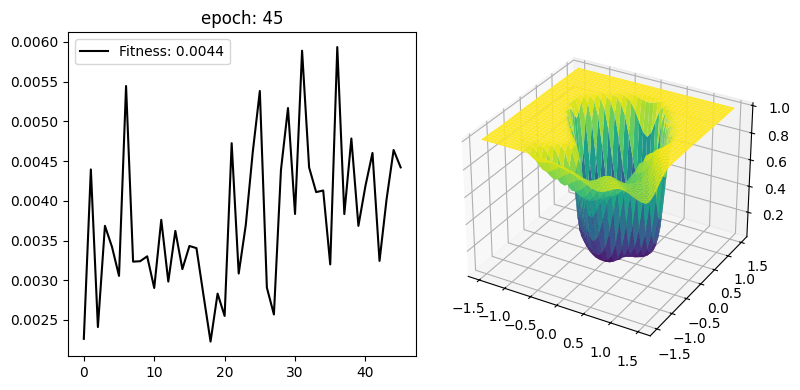

In [410]:
#Robots = GetRobots(80)
RobotsLuegodeClase = Genetic(Robots,epochs=50,Plot=True)

In [411]:
for i,p in enumerate(RobotsLuegodeClase):
  p.Reset()
  #print(RobotsLuegodeClase[i].r)

In [412]:
bestbrain = RobotsLuegodeClase[0].GetBrain()
Bot = Robot(dt,bestbrain,Id=0)

In [413]:
x = np.linspace(-1.5,1.5,40)
y = np.linspace(-1.5,1.5,40)
X,Y = np.meshgrid(x,y)
N = np.zeros_like(X)

for i in range(40):
  for j in range(40):
    N[i,j]  = Bot.BrainActivation(np.array([x[i],y[j]]))

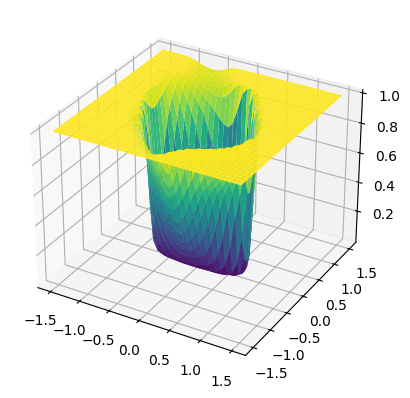

In [414]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,N,cmap='viridis')

In [415]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=N)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.show()

In [417]:
TestBots = []
for i in range(5):
  TestBots.append(Robot(dt,bestbrain,Id=i))
TimeEvolution(TestBots,True)

KeyboardInterrupt: 